## MCMC sampling of the Gibbs distribution for a 2D Ising model

In [65]:
import math
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize']=20,20

The goal of this notebook is to apply a few MCMC sampling methods to the Gibbs distribution of the Ising Model on a two dimensional periodic lattice.
This model is described by the following:
- The set $S=\{\pm 1\}$ of **spin states**
- A real parameter $\beta>0$, the **inverse temperature**
- A parameter $L\in\mathbb N$,the **length**, and the corresponding graph $G_L=(V_L=\mathbb Z/L\mathbb Z\times \mathbb Z /L\mathbb Z,E_L)$, where $(x,y)\sim (x',y')$ in $G_L$ if and only if $\{x-x',y-y'\}=\{0,1\}$ or $\{0,-1\} \mod L$
- An element $\sigma$ of $S^{V_L}$ is called a **spin configuration**.

For any spin configuration $\sigma\in S^{V_L}$, define its **energy** by:
$$H(\sigma)=-\sum_{u\in V_L}\sum_{v\sim u} \sigma_u\cdot \sigma_v=-\sum_{\{u,v\}\in E_L}\sigma_u\cdot \sigma_v$$
Thus low-energy configurations are those where neighboring spins are equal, with the lowest possible energy states being the two constant configurations (the **ground states**).
The **Gibbs distribution** of the Ising model is a probability distribution on the set of spin configurations, where a particular configuration $\sigma$ is picked with a probability proportional to $e^{-\beta H(\sigma)}$, thus if $X$ is Gibbs-distributed, we can write

$$\mathbb P (X=\sigma)=\frac1{Z_\beta}e^{-\beta H(\sigma)}$$

Where $Z_\beta$ is a normalizing constant given by
$$Z_\beta=\sum_{\sigma\in S^{V_L}}e^{-\beta H(\sigma)}$$

The Gibbs distribution thus generally exponentially favors low-energy configurations, but the strength of this favoritism is controlled by the inverse temperature $\beta$:
- If $\beta=0$, then the Gibbs distribution is uniform on the set of spin configurations, so there is no preference for low-energy configurations
- At the other extreme, as $\beta \to \infty$, the Gibbs distribution concentrates on the lowest-energy configurations, which we have identified as the two constant ground states.

Another important observation is that in general, the constant $Z_\beta$ is hard to compute: this sum has $2^{L^2}$ terms, each of which depends on the details of a certain spin-configuration, so ideally we should aim to find a method for sampling from the Gibbs distribution whithout having to go through the trouble of computing $Z_\beta$.

There is a notable exception: for $\beta=0$, then all of these terms are $1$, hence $Z_0=2^{L^2}$. Note in this case the Gibbs distribution coincides with the product measure $\mathcal U^{\otimes |V_L|}$, where $\mathcal U$ is uniform on $S$. Thus we get our first way to sample from the Gibbs distribution in the special case $\beta=0$.

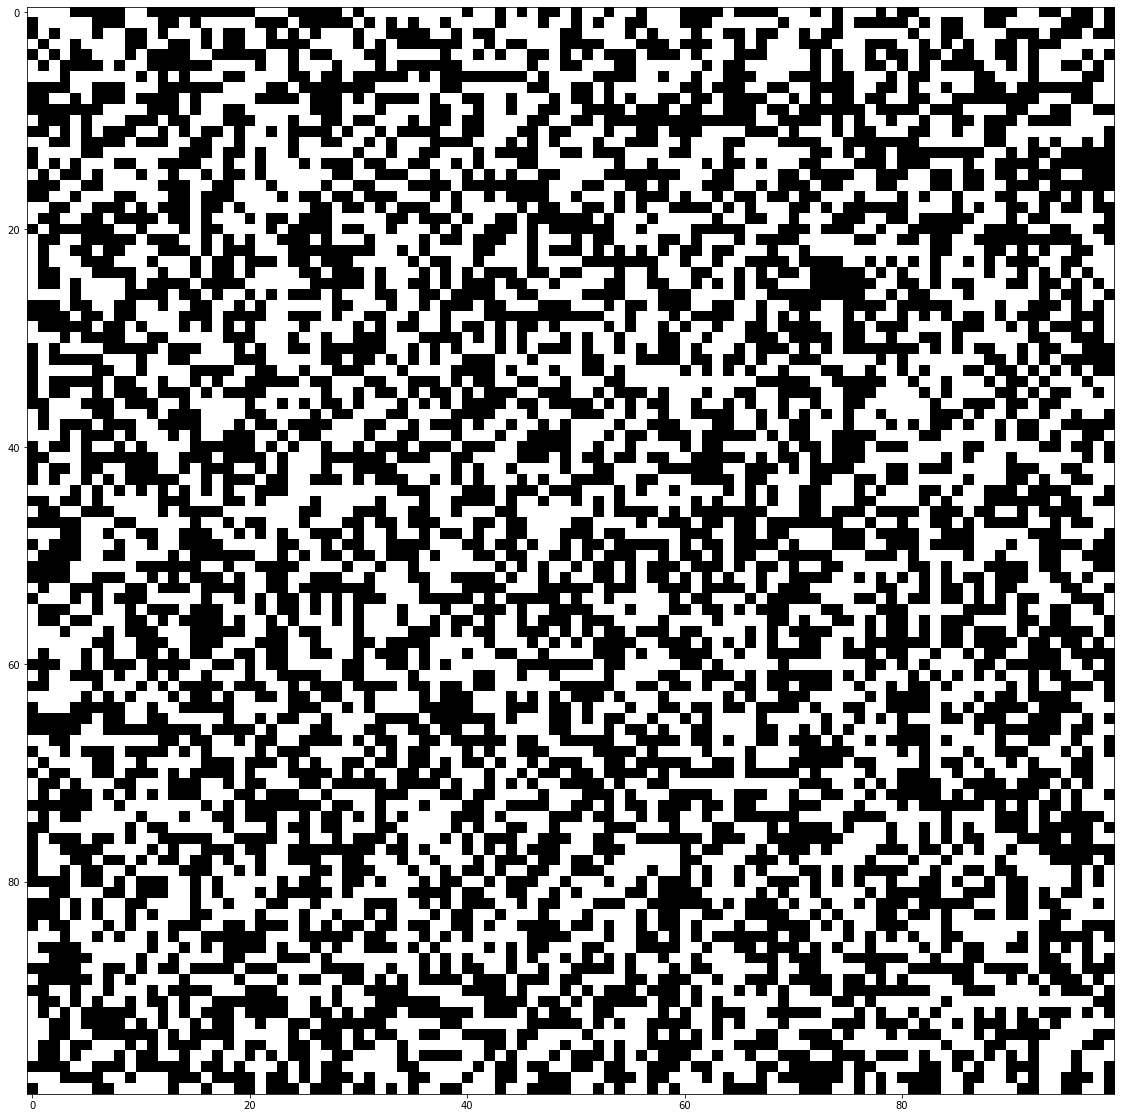

In [66]:
L=100
beta=0

X=(-np.ones((L,L)))**np.random.randint(2,size=(L,L))

plt.imshow(X,cmap='gray')
plt.show()

Now we turn to $\beta>0$. In this case, for large $L$, computing $Z_\beta$ is intractable. Fortunately, the Metropolis algorithm allows us to avoid this obstacle. We will define a Markov chain $(X_n)_{n\geq 0}$ on the space of spin configurations which is reversible with respect to the Gibbs distribution. The ergodic theory of Markov chains will allow us to conclude that, since the distribution of $X_n$ converges to the unique stationnary distribution, in one of several possible senses we do not detail here, one can sample an approximately Gibbs distributed spin configuration by picking $X_n$ for $n$ large enough.\
The description of the Metropolis algorithm is straightforward, so we go through its derivation briefly.

Given a **state space** $E$ and a probability measure $\pi$ on $E$, the goal is to sample $E\ni X\sim \pi$.\
The ingredients are the following:
- A way to sample a starting state, $X_0\in E$
- A way to randomly transition from one state to another, that is, a stochastic matrix $Q:E\times E\mapsto [0,1]$, verifying the technical condition $Q(x,y)>0\iff Q(y,x)>0$
- A function $F:(0,+\infty)\mapsto (0,1]$ with the property $F(r)=rF(\frac1r)\ \forall r>0$
- An i.i.d. sequence $(U_n)_{n\geq 1}\sim \mathcal U([0,1])^{\otimes \mathbb N}$, independent from $X_0$

In practice we chose $F(r)=\min(1,r)$ or $F(r)=\frac{r}{1+r}$.

### Metropolis Algorithm
\
Define the Markov Chain $(X_n)_{n\geq 0}$ by 
$$X_{n+1}=\begin{cases}X_n && U_{n+1}> F(r(X_n,Y_n))\\ Y_n && \text{otherwise} \end{cases},\ n\geq 0$$

Where $Y_n$ is sampled from $Q(X_n,\cdot)$ independently from $(U_n)_n$ (so that $(X_n,Y_n)$ is a $Q$-Markov chain), and $r(X_n,Y_n)$ is defined by:

$$r(x,y)=\frac{\pi(y)Q(y,x)}{\pi(x)Q(x,y)}$$

Note this ratio is well-defined owing to the condition on $Q$. The claim is that $(X_n)_n$ is reversible with respect to $\pi$.
Write, for $x\neq y \in E$, with $P$ being the transition matrix for $(X_n)_n$, and omitting to spell out the trivial case $x=y$

$$\begin{align}\pi(x)P(x,y) &&= &&\pi(x)Q(x,y)F(r(x,y)) &&\quad{(\text{using independence of }U_{n+1} \text{ and } Y_n})\\
                          &&= &&\pi(x)Q(x,y)F(\frac{\pi(y)Q(y,x)}{\pi(x)Q(x,y)})&&\\
                          &&= &&\frac{\pi(x)Q(x,y)\pi(y)Q(y,x)}{\pi(x)Q(x,y)}F(\frac{\pi(x)Q(x,y)}{\pi(y)Q(y,x)})&&\quad{(\text{using }F(r)=rF(\frac1r)\ \forall r>0)}\\
                          &&= &&\pi(y)Q(y,x)F(r(y,x))&&\\
                          &&=  &&\pi(y)P(y,x)&&\end{align}$$

It is straightforward to verify that this chain is irreducible, and hoping it is aperiodic (we can show it is for $F(r)=\frac{r}{1+r}$), then the distribution of $X_n$ approaches $\pi$. Note the crucial observation that at no point is it required to evaluate $\pi(x)$ and $\pi(y)$, but only the *ratio* $\frac{\pi(x)}{\pi(y)}$, so this method is useful is the target distribution is easy to  evaluate *up to a normalizing constant*, since this constant cancels out in the ratio. Fortunately, this is exactly our predicament!

In our case, $E=S^{V_L}$. Let us define the transition $Q$ by the following dynamical description: if $Y_0$ is given and $(V_n)_{n\geq 1}$ is an *i.i.d.* sequence of uniform random variables on $V_L$, independent from $Y_0$, define the Markov chain $(Y_n)_{n\geq 0}$ for $n\geq 1$ by
$$Y_n=\phi(Y_{n-1},V_n)$$
$$\phi: E\times V_L\mapsto E$$
$$\phi(\sigma,v)_u=\begin{cases}\sigma_u && u\neq v \\ -\sigma_u && u=v\end{cases}$$
In words, the proposed transition is achieved by flipping the spin at a site chosen uniformly at random. Finally define $Q$ to be the transition kernel for this Markov chain. It is clear then that for any $\sigma,\tau$ such that $Q(x,y)>0$, we have $Q(x,y)=Q(y,x)=\frac1{|V_L|}=\frac1{L^2}$, thus the technical assumption is verified, and furthermore, the $Q$ terms simplify in the expression of of $r(\sigma,\tau)$, so that
$$r(X_n,Y_n)=\frac{\pi(Y_n)}{\pi(X_n)}=\frac{e^{-\beta H(Y_n)}}{e^{-\beta H(X_n)}}=e^{-\beta(H(Y_n)-H(X_n))}$$

Now remember that $Y_n=\phi(X_n,V_n)$. Examining the definition of $H$, we have some cancellations of terms:

$$H(\sigma)-H(\phi(\sigma,v))=-\left(\sum_{\{s,t\}\in E_L}\sigma_s\cdot \sigma_t-\sum_{\{s,t\}\in E_L}\phi(\sigma,v)_s\cdot \phi(\sigma,v)_t\right)$$
$$=-\left(\sum_{\{s,t\}\in E_L, v\not\in \{s,t\}}\sigma_s\cdot \sigma_t +\sum_{\{s,v\}\in E_L}\sigma_s\cdot \sigma_v -\sum_{\{s,t\}\in E_L,v\not\in \{s,t\}}\phi(\sigma,v)_s\cdot \phi(\sigma,v)_t-\sum_{\{s,v\}\in E_L}\phi(\sigma,v)_s\cdot \phi(\sigma,v)_v\right) $$
$$=-\left(\sum_{\{s,t\}\in E_L, v\not\in \{s,t\}}\sigma_s\cdot \sigma_t +\sum_{\{s,v\}\in E_L}\sigma_s\cdot \sigma_v -\sum_{\{s,t\}\in E_L,v\not\in \{s,t\}}\sigma_s\cdot \sigma_t-\sum_{\{s,v\}\in E_L}-\sigma_s\cdot \sigma_v\right)$$
$$=-2\sum_{u\sim v} \sigma_u\cdot \sigma_v=-2\sigma_v\sum_{u\sim v}\sigma_u$$


Let us finally summarize our
### Metropolis Algorithm for the Ising model

Given:
- $X_0$ according to the $\beta=0$ Gibbs distribution
- An *i.i.d.* sequence $(V_n)_{n\geq 1}$ independent from $X_0$ of uniformly random vertices of $G_L$
- An *i.i.d.* sequence $(U_n)_{n\geq 1}$ independent from $X_0$ and $(V_n)_n$ of $\mathcal U(0,1)$ random variables
- $F$ defined by $F(r)=\frac{r}{1+r}$

Construct $X_n$ recursively by the following procedure, until $n=N$, where $N$ is some cutoff parameter given as input to the algorithm.\ 
1. Sample $V_n$.
2. Compute $r_n=\exp\left(-2\beta X_n(V_n)(\sum_{u\sim V_n}X_n(u))\right)$
3. If $U_n\leq F(r_n)$, set $X_{n+1}=\phi(X_n,V_n)$, otherwise set $X_{n+1}=X_n$
4. Increment $n$ and return to step 1.

When this process is over, return $X_N$


In [67]:
F_barker=lambda r:r/(1+r)
neighborhood_vectors=[[0,-1],[0,1],[-1,0],[1,0]]

In [68]:
def sample_metropolis(L,beta,N,F=F_barker):
    X=(-np.ones((L,L)))**np.random.randint(2,size=(L,L))
    U=np.random.random(N)
    V=np.random.randint(L,size=(N,2))
    for i in range(N):
        S=sum(X[(V[i,0]+d[0])%L,(V[i,1]+d[1])%L]for d in neighborhood_vectors)
        r=math.exp(-2*beta*X[V[i,0],V[i,1]]*S)
        if U[i]<=F(r):
            X[V[i,0],V[i,1]]*=-1
    return X
            

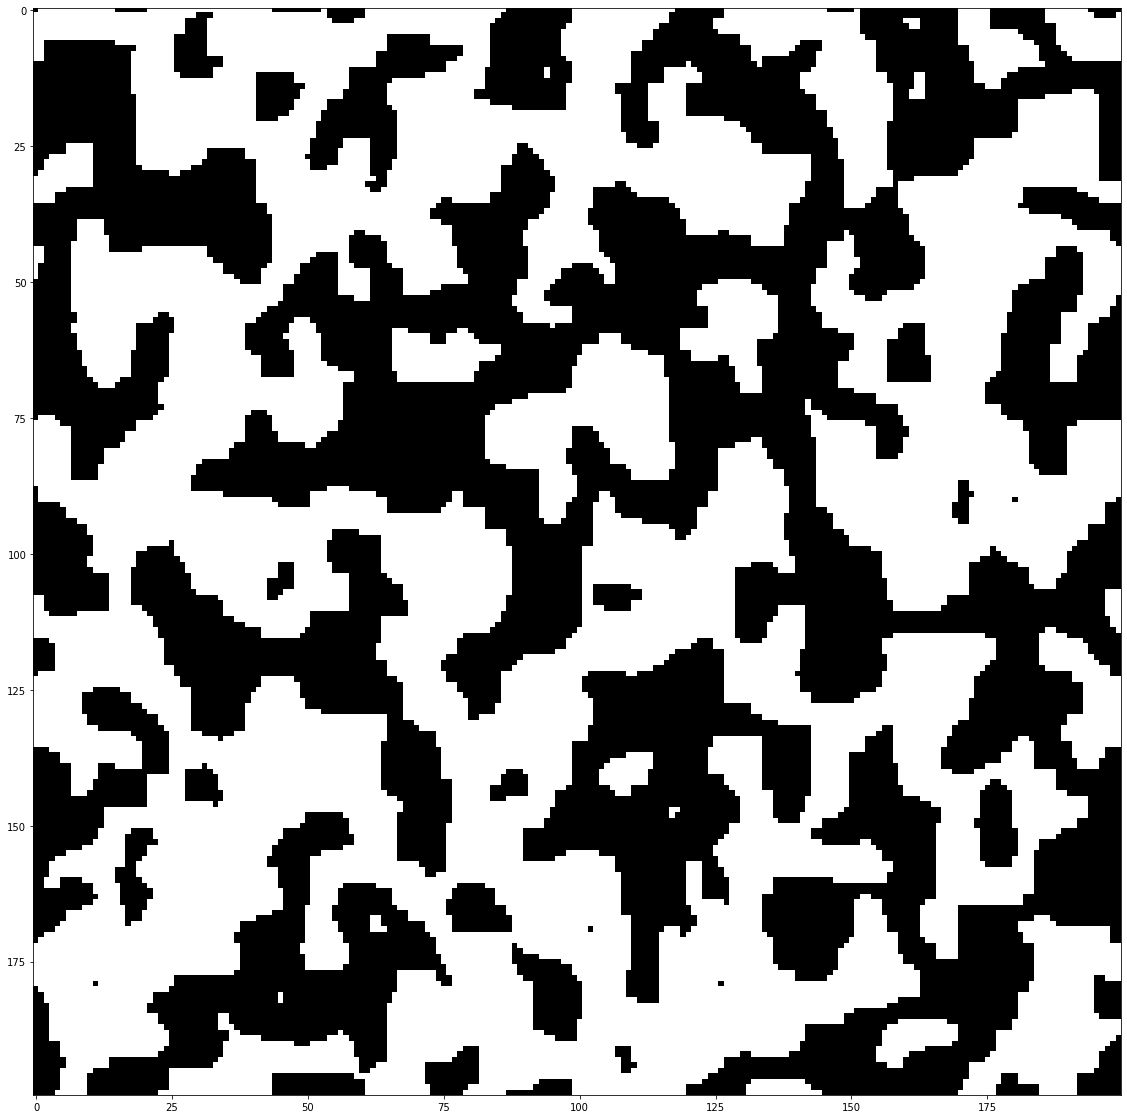

In [71]:
X=sample_metropolis(200,5,1000000)

plt.imshow(X,cmap='gray')
plt.show()

For the sake of comparison, we can check if changing $F$ affects the speed or the quality of the result:

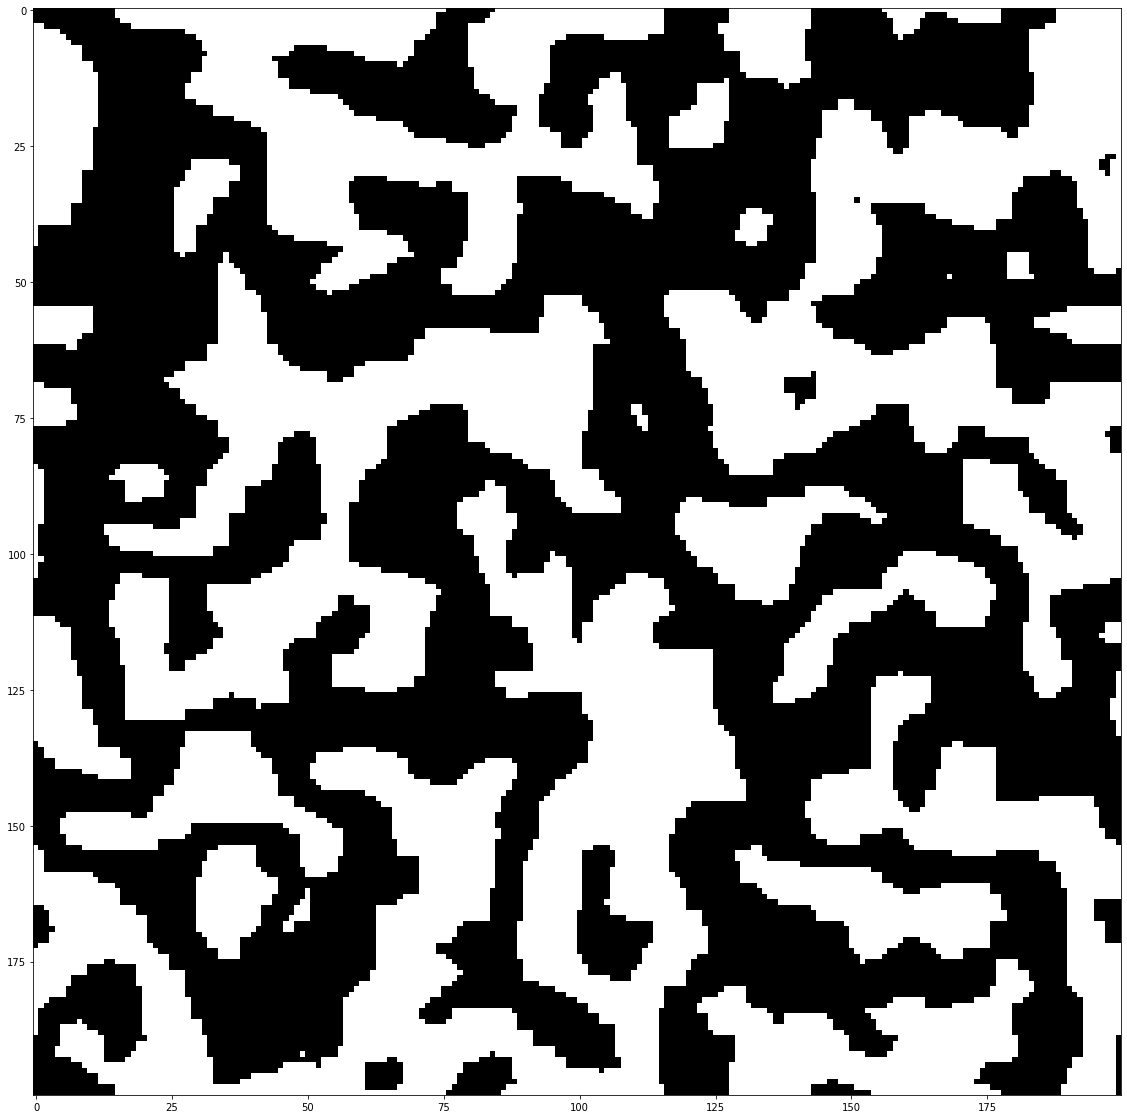

In [70]:
F_metropolis_hastings=lambda r:min(1,r)

X=sample_metropolis(200,5,1000000,F=F_metropolis_hastings)

plt.imshow(X,cmap='gray')
plt.show()

One inconvenient aspect of this method is that each spin is updated randomly, so that a coupon-collector's problem is in effect, if we want to get each spin to get updated multiple times in order to get a fair estimation.
One possibility is to visit each spin in a set (deterministic) sequence. This amounts to making the $(V_n)_n$ into a non-stationnary deterministic sequence. The transition $P$ becomes a family of transitions $P_n$, each of which is reversible with respect to the Gibbs distribution. One natural choice is to scan the coordinates in lexicographic order.

In [72]:
def sample_metropolis_glauber(L,beta,N,F=F_barker):
    X=(-np.ones((L,L)))**np.random.randint(2,size=(L,L ))
    U=np.random.random(N)
    V=np.zeros((N,2))
    V[:,0]=np.arange(N)//L
    V[:,1]=np.arange(N)
    V%=L
    V=V.astype(np.int)
    for i in range(N):
        S=sum(X[(V[i,0]+d[0])%L,(V[i,1]+d[1])%L]for d in neighborhood_vectors)
        r=np.exp(-2*beta*X[V[i,0],V[i,1]]*S)
        if U[i]<=F(r):
            X[V[i,0],V[i,1]]*=-1
    return X

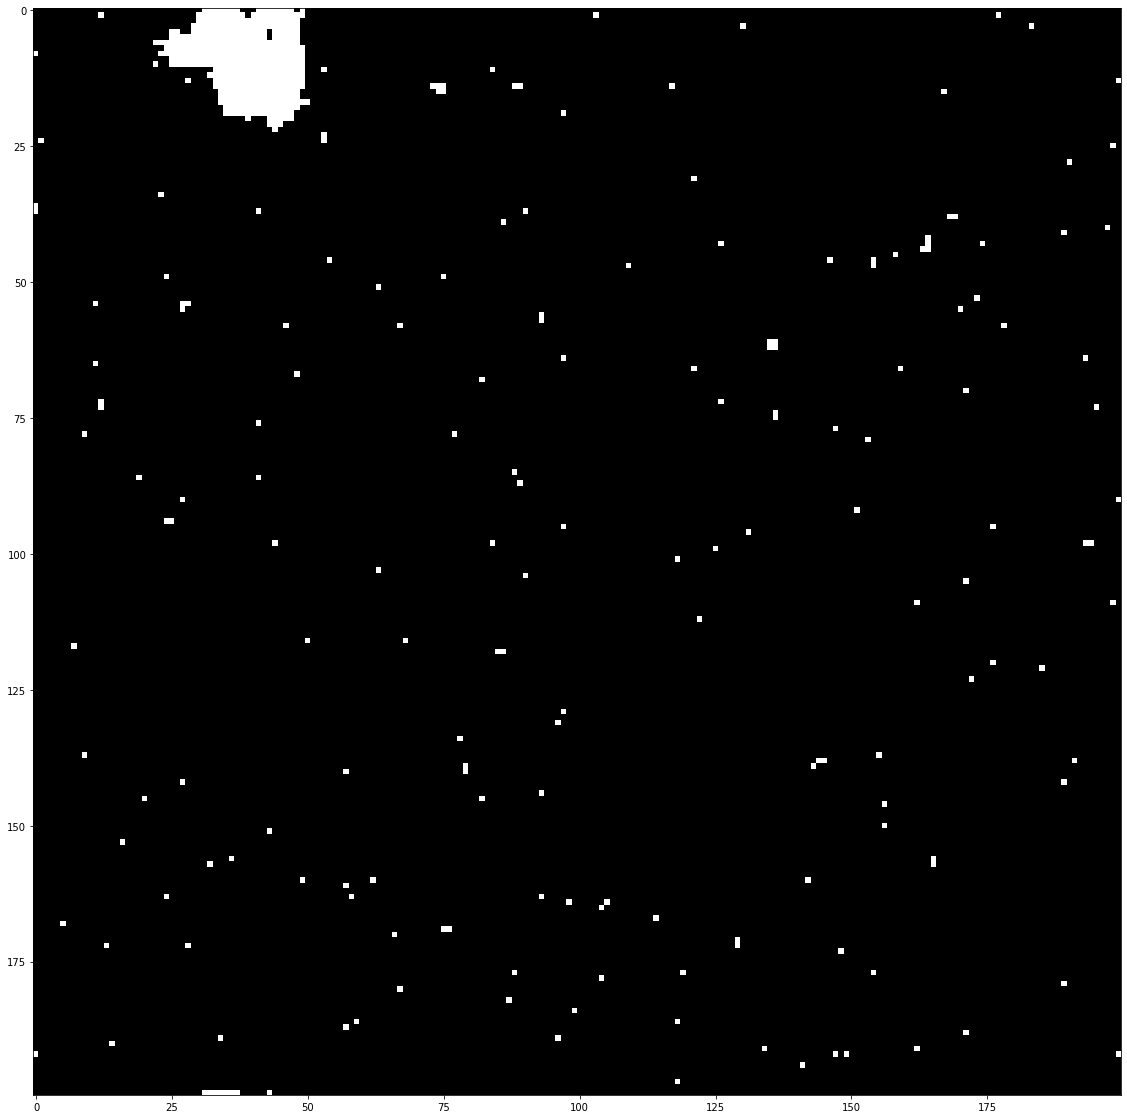

In [75]:
X=sample_metropolis_glauber(200,0.7,10000000,F=F_metropolis_hastings)

plt.imshow(X,cmap='gray')
plt.show()